# Quick-and-dirty experimental image viewer

In [1]:
#%matplotlib inline
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from skimage import data, img_as_float
from skimage import exposure
from PIL import Image

dictBands = {'b': (0,2), 'g': (1,1), 'r': (2,0)}


/home/lisa/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/lisa/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  return f(*args, **kwds)


In [2]:
plt.rcParams["figure.figsize"] = (20,12)

In [3]:
WORKDIR = "/home/lisa/Schreibtisch/Projekt/roadDetection/data/"

imDir  = "/home/lisa/Schreibtisch/Projekt/roadDetection/data/data/sat/"
mapDir  = "/home/lisa/Schreibtisch/Projekt/roadDetection/data/data/map/"
metaDir = "/home/lisa/Schreibtisch/Projekt/roadDetection/data/sat_images/3093/"
shpDir  = "/home/lisa/Schreibtisch/Projekt/roadDetection/data/labels/Borneo/3093"
imName =  "AnalyticMS_tile_0-1500.tif"
filename = imDir+imName#"20170623_180038_0f34_3B_AnalyticMS.tif"
mapname = mapDir+imName

print(rio.open(filename).meta)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 1500, 'height': 1500, 'count': 4, 'crs': CRS({'init': 'epsg:32750'}), 'transform': Affine(3.0, 0.0, 397590.0,
       0.0, -3.0, 9818313.0)}


In [140]:
data_dir = "/media/hh/hd_internal/_data_DS/DSR/satelliteImages/Borneo/3093/"
# AnalyticMS_SR
dataset = gdal.Open(filename, gdal.GA_ReadOnly)
nLayer = dataset.RasterCount
for k in range(1, dataset.RasterCount + 1):
    band = dataset.GetRasterBand(k)
    if k == 1:
        imgArr = band.ReadAsArray()
        sz = np.shape(imgArr)
        imgArr = imgArr.reshape((sz[0], sz[1], 1))
    else:
        imgArr = np.append(imgArr, band.ReadAsArray().reshape((sz[0], sz[1], 1)), axis = 2)


In [141]:
data_dir = "/media/hh/hd_internal/_data_DS/DSR/satelliteImages/Borneo/3093/"
# AnalyticMS_SR
dataset = rio.open(filename)
nLayer = dataset.RasterCount
for k in range(1, dataset.RasterCount + 1):
    band = dataset.GetRasterBand(k)
    if k == 1:
        imgArr = band.ReadAsArray()
        sz = np.shape(imgArr)
        imgArr = imgArr.reshape((sz[0], sz[1], 1))
    else:
        imgArr = np.append(imgArr, band.ReadAsArray().reshape((sz[0], sz[1], 1)), axis = 2)


AttributeError: 'DatasetReader' object has no attribute 'RasterCount'

In [4]:
def transform2visible(inds, bands):
    imgArr = inds.read()
    sz = np.shape(imgArr)
    print(sz)
    visArray = np.zeros((sz[1], sz[2], 3), 'uint8')   
    
    for k in bands:
        planetScopeIndex, RGBIndex  = dictBands[k]
        # Normalize each band-image
        ima = (imgArr[planetScopeIndex][:,:])
        img = (ima.astype('float')/ima.max())

        # Adaptive Equalization
        img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

        visArray[..., RGBIndex] = img_adapteq*256
    return visArray

In [5]:
def write_visible(src, meta):
    outpath = 'test.tif'
    with rio.open(outpath, 'w', **meta) as outds:
        sz = np.shape(src)
        print(sz)
        output  = np.zeros(( sz[0], sz[1]), 'uint8')  
        print(output.shape)
        for i in range(3):
            output += src[..., i]
        output = output/3
        
        outds.write(output.astype(np.uint8), 1)
        
        


{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 1500, 'height': 1500, 'count': 4, 'crs': CRS({'init': 'epsg:32750'}), 'transform': Affine(3.0, 0.0, 397590.0,
       0.0, -3.0, 9818313.0)}
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 1500, 'height': 1500, 'count': 3, 'crs': CRS({'init': 'epsg:32750'}), 'transform': Affine(3.0, 0.0, 397590.0,
       0.0, -3.0, 9818313.0)}
(4, 1500, 1500)


/home/lisa/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


[[ 7  7  7 ... 62 60 61]
 [ 7  7  7 ... 61 58 60]
 [ 7  7  7 ... 60 58 60]
 ...
 [ 0  0  0 ... 65 63 64]
 [ 0  0  0 ... 66 63 62]
 [ 0  0  0 ... 65 63 63]]


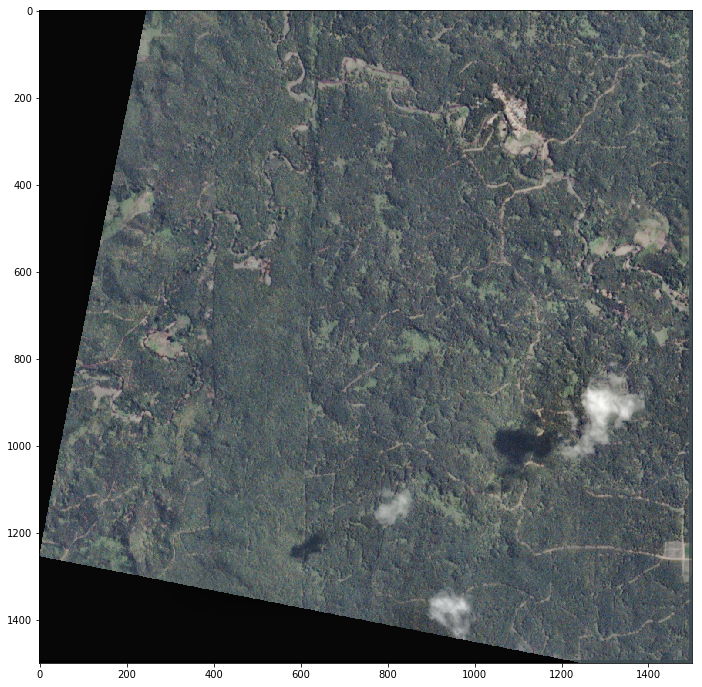

(1500, 1500, 3)
(1500, 1500)


In [8]:
def make_visible(file):
    with rio.open(file) as inds:
        meta = inds.meta.copy()   
        print(meta)
        meta['dtype'] = 'uint8'
        meta['count'] = 3
        nodata=7
        print(meta)
        rgbImage = transform2visible(inds, ['b', 'g', 'r'])
        
        print(rgbImage[..., 0])
        plt.imshow(rgbImage)
        plt.show()   
        write_visible(rgbImage, meta)
        
        #write_tile(inds, window, meta, ax)
make_visible(filename)

In [7]:
def plot_img_and_hist(img, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    img = img_as_float(img)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(img, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(img.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(img, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf




def plot_histograms(img, img_adapteq):
    # Display results
    f, axes = plt.subplots(2,2, figsize=(8, 4))

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
    ax_img.set_title('Low contrast image')

    y_min, y_max = ax_hist.get_ylim()
    ax_hist.set_ylabel('Number of pixels')
    ax_hist.set_yticks(np.linspace(0, y_max, 5))

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 1])
    ax_img.set_title('Adaptive equalization')

    ax_cdf.set_ylabel('Fraction of total intensity')
    ax_cdf.set_yticks(np.linspace(0, 1, 5))

    # prevent overlap of y-axis labels
    plt.subplots_adjust(wspace=0.4)



visArray = transform2visible(imgArr, ['r','g','b'])

plt.show()

NameError: name 'imgArr' is not defined

NameError: name 'rgbImage' is not defined